In [214]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import ydf

### Splitting the data into training and testing data.

In [215]:
dataset = pd.read_csv('churn_dataset.csv')

from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset.iloc[:,1:], test_size=0.2, random_state=47)

### Model Building

In [216]:
forest_model = ydf.RandomForestLearner(
    label='churn',
    num_trees=500, 
    max_depth=16
)

forest_model = forest_model.train(train)

Train model on 11614 examples


max_vocab_count = -1 for column churn, the dictionary will not be pruned by size.
Data spec:
Number of records: 11614
Number of columns: 50

Number of columns by type:
	NUMERICAL: 47 (94%)
	CATEGORICAL: 3 (6%)

Columns:

NUMERICAL: 47 (94%)
	2: "forecast_discount_energy" NUMERICAL mean:0.995609 min:0 max:30 sd:5.1836 dtype:DTYPE_FLOAT64
	3: "has_gas" NUMERICAL mean:0.185294 min:0 max:1 sd:0.388536 dtype:DTYPE_INT64
	4: "margin_net_pow_ele" NUMERICAL mean:24.5683 min:0 max:374.64 sd:19.8326 dtype:DTYPE_FLOAT64
	5: "nb_prod_act" NUMERICAL mean:1.29697 min:1 max:32 sd:0.72251 dtype:DTYPE_INT64
	6: "net_margin" NUMERICAL mean:188.498 min:0 max:10203.5 sd:239.988 dtype:DTYPE_FLOAT64
	8: "pow_max" NUMERICAL mean:18.1732 min:3.3 max:320 sd:13.7262 dtype:DTYPE_FLOAT64
	9: "current_cons_trend" NUMERICAL mean:0.905551 min:-2 max:15.3158 sd:1.05494 dtype:DTYPE_FLOAT64
	10: "ln_cons_12m" NUMERICAL mean:9.73475 min:0 max:15.6412 sd:2.04038 dtype:DTYPE_FLOAT64
	11: "ln_cons_gas_12m" NUMERICAL mean:1

Model trained in 0:00:02.068749


### Model Testing

In [218]:
print(f"No information rate: {(1 - dataset[dataset['churn'] == 1].size / dataset[dataset['churn'] == 0].size)}")

No information rate: 0.8933607744492721


In [217]:
evaluation = forest_model.evaluate(test)
evaluation

Model loaded with 500 root(s), 409304 node(s), and 49 input feature(s).
Engine "RandomForestOptPred" built


Label \ Pred,0,1
0,2633,263
1,0,8


#### No false positives. Model is struggling to predict true values however.

### Model gives significant performance over the no information rate, but definitely has room for improvement, whether that be a different model structure or more data.

<Axes: >

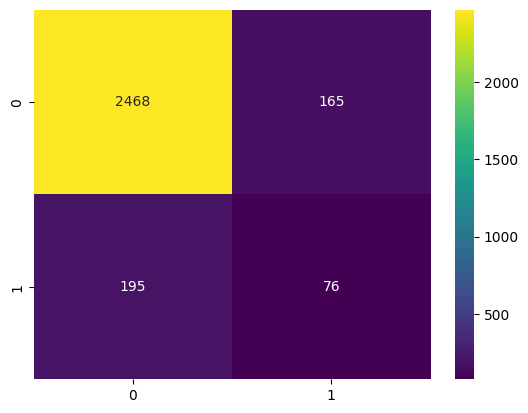

In [227]:
from sklearn.metrics import confusion_matrix

pred_threshold = 0.15
y_true = test['churn']
y_pred = (forest_model.predict(test) > pred_threshold).astype(int)

sns.heatmap(confusion_matrix(y_true, y_pred), cmap='viridis', annot=True, fmt='.0f')

#### A smaller threshold allows the model to find more churned customers, but reduces the reliability of churn predictions.

#### Threshold tuning is required in this case for the desired outcome of the model, which should be whatever balance is desired between positive predictive value and sensitivity.

In [219]:
forest_model.describe()

#### The margins of a specific customer seem to be the most importance feature for prediciting customer churn.
#### The number of weeks a customer has been a client also seems to matter the most, as well as the campaign they signed up for, as well as the ln of their consumption in the past 12 months.